2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\sharm\anaconda3\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\sharm\AppData\Local\Temp\ipykernel_14688\1916463653.py", line 193, in fetch_and_plot_history
    self.plot_history(df, symbol)
  File "C:\Users\sharm\AppData\Local\Temp\ipykernel_14688\1916463653.py", line 212, in plot_history
    cursor.connect("add", lambda sel: sel.annotation.set_text(f"Price: ${sel.target[1]:.2f}"))
    ^^^^^^
NameError: name 'cursor' is not defined


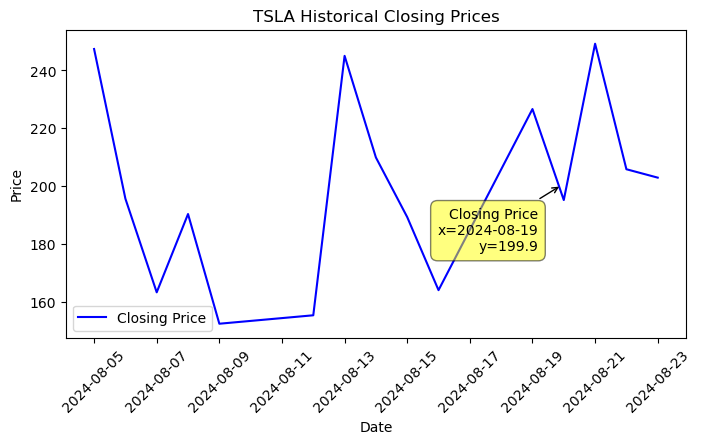

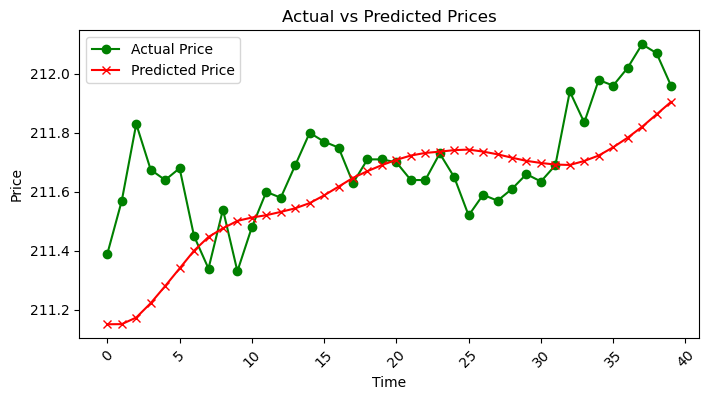

In [4]:
import tkinter as tk
from tkinter import ttk, messagebox
from tkcalendar import DateEntry
import pandas as pd
import numpy as np
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from datetime import datetime
import pytz
import mplcursors

# Load the pre-trained model (Ensure you have a trained model saved as 'model.h5')
model = load_model('model.h5')
model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model to avoid warnings

# API key
API_KEY = 'DL1EMTWQB5HLJD5B'  

# Function to fetch real-time stock data
def fetch_stock_data(symbol):
    try:
        api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&apikey={API_KEY}'
        response = requests.get(api_url)
        data = response.json()
        if 'Time Series (5min)' not in data:
            raise ValueError("Invalid API response")
        df = pd.DataFrame(data['Time Series (5min)']).T
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        df['close'] = df['close'].astype(float)
        df['datetime'] = pd.to_datetime(df.index)
        df.set_index('datetime', inplace=True)
        df = df.sort_index()
        return df
    except Exception as e:
        messagebox.showerror("Error", f"Failed to fetch data: {e}")
        return None

# Function to preprocess data and make prediction
def predict_stock(symbol):
    df = fetch_stock_data(symbol)
    if df is not None:
        # Preprocess data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df[['close']])
        
        if len(scaled_data) < 60:
            messagebox.showwarning("Data Error", "Not enough data to make a prediction. Please try a different stock symbol.")
            return None, None, None
        
        X_test = []
        for i in range(60, len(scaled_data)):
            X_test.append(scaled_data[i-60:i, 0])
        
        if len(X_test) == 0:
            messagebox.showwarning("Data Error", "Not enough data points to create input sequences.")
            return None, None, None
        
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        # Make prediction
        predicted_stock_price = model.predict(X_test)
        predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
        
        # Get the prediction time
        prediction_time = df.index[-1] + pd.Timedelta(minutes=5)  # Assuming data is fetched every 5 minutes
        
        return df['close'][-len(predicted_stock_price):].values, predicted_stock_price.flatten(), prediction_time
    else:
        return None, None, None

# Placeholder function to simulate fetching historical data
def fetch_historical_data(symbol, start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='B')  # Business days
    prices = np.random.uniform(low=150, high=250, size=len(dates))
    df = pd.DataFrame(data={'date': dates, 'close': prices})
    df.set_index('date', inplace=True)
    return df

class StockPredictionApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("NasDock")

        # Create a canvas and a scrollbar
        self.canvas = tk.Canvas(self)
        self.scrollbar = tk.Scrollbar(self, orient="vertical", command=self.canvas.yview)
        self.scrollable_frame = tk.Frame(self.canvas)

        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: self.canvas.configure(
                scrollregion=self.canvas.bbox("all")
            )
        )

        self.canvas.create_window((0, 0), window=self.scrollable_frame, anchor="nw")
        self.canvas.configure(yscrollcommand=self.scrollbar.set)

        self.canvas.pack(side="left", fill="both", expand=True)
        self.scrollbar.pack(side="right", fill="y")

        # Stock symbol entry with auto-capitalization
        self.stock_var = tk.StringVar()
        self.stock_var.trace_add('write', self.capitalize_stock_entry)
        tk.Label(self.scrollable_frame, text="Enter Stock Symbol").pack()
        self.stock_entry = tk.Entry(self.scrollable_frame, textvariable=self.stock_var)
        self.stock_entry.pack()

        # Predict button
        self.predict_button = tk.Button(self.scrollable_frame, text="Predict", command=self.predict_price)
        self.predict_button.pack()

        # Prediction result label
        self.prediction_label = tk.Label(self.scrollable_frame, text="")
        self.prediction_label.pack()

        # MAE label
        self.mae_label = tk.Label(self.scrollable_frame, text="")
        self.mae_label.pack()

        # Current time label
        self.clock_label = tk.Label(self.scrollable_frame, text="")
        self.clock_label.pack()

        # Historical data section
        tk.Label(self.scrollable_frame, text="Historical Data").pack()
        self.start_date_entry = DateEntry(self.scrollable_frame, width=12, background='darkblue', foreground='white', borderwidth=2)
        self.start_date_entry.pack(padx=10, pady=10)
        self.end_date_entry = DateEntry(self.scrollable_frame, width=12, background='darkblue', foreground='white', borderwidth=2)
        self.end_date_entry.pack(padx=10, pady=10)

        self.fetch_button = tk.Button(self.scrollable_frame, text="Fetch Historical Data", command=self.fetch_and_plot_history)
        self.fetch_button.pack()

        # Matplotlib figure and axis for historical data
        self.fig_history, self.ax_history = plt.subplots(figsize=(8, 4))
        self.canvas_history = FigureCanvasTkAgg(self.fig_history, master=self.scrollable_frame)
        self.canvas_history.get_tk_widget().pack()

        # Matplotlib figure and axis for prediction vs actual
        self.fig_prediction, self.ax_prediction = plt.subplots(figsize=(8, 4))
        self.canvas_prediction = FigureCanvasTkAgg(self.fig_prediction, master=self.scrollable_frame)
        self.canvas_prediction.get_tk_widget().pack()

        # Update the clock every second
        self.update_clock()

    def capitalize_stock_entry(self, *args):
        self.stock_var.set(self.stock_var.get().upper())

    def predict_price(self):
        symbol = self.stock_entry.get().upper()  # Ensure uppercase input
        if symbol:
            actual_prices, predicted_prices, prediction_time = predict_stock(symbol)
            if actual_prices is not None and predicted_prices is not None and prediction_time is not None:
                prediction_time_str = prediction_time.strftime("%Y-%m-%d %H:%M:%S")
                self.prediction_label.configure(text=f"Predicted Stock Price for {symbol} at {prediction_time_str}: ${predicted_prices[-1]:.2f}")
                self.plot_predictions(actual_prices, predicted_prices)
                
                # Calculate Mean Absolute Error (MAE)
                mae = np.mean(np.abs(actual_prices - predicted_prices))
                self.mae_label.configure(text=f"Mean Absolute Error (MAE): ${mae:.2f}")
            else:
                self.prediction_label.configure(text="Prediction failed. Please try again.")
                self.mae_label.configure(text="")
        else:
            messagebox.showwarning("Input Error", "Please enter a valid stock symbol.")

    def plot_predictions(self, actual, predicted):
        self.ax_prediction.clear()
        self.ax_prediction.plot(actual, label='Actual Price', color='green', marker='o')
        self.ax_prediction.plot(predicted, label='Predicted Price', color='red', marker='x')
        self.ax_prediction.set_title('Actual vs Predicted Prices')
        self.ax_prediction.set_xlabel('Time')
        self.ax_prediction.set_ylabel('Price')
        self.ax_prediction.legend()
        self.ax_prediction.tick_params(axis='x', labelrotation=45)
        self.ax_prediction.tick_params(axis='y')
        self.canvas_prediction.draw()

    def fetch_and_plot_history(self):
        symbol = self.stock_entry.get().upper()  # Ensure uppercase input
        start_date = self.start_date_entry.get_date()
        end_date = self.end_date_entry.get_date()
        
        if symbol:
            df = fetch_historical_data(symbol, start_date, end_date)
            if df is not None:
                self.plot_history(df, symbol)
            else:
                messagebox.showwarning("Data Error", "Failed to fetch historical data.")
        else:
            messagebox.showwarning("Input Error", "Please enter a valid stock symbol.")
    
    def plot_history(self, df, symbol):
        self.ax_history.clear()
        line, = self.ax_history.plot(df.index, df['close'], label='Closing Price', color='blue')
        self.ax_history.set_title(f'{symbol} Historical Closing Prices')
        self.ax_history.set_xlabel('Date')
        self.ax_history.set_ylabel('Price')
        self.ax_history.legend()
        self.ax_history.tick_params(axis='x', labelrotation=45)
        self.ax_history.tick_params(axis='y')
        self.canvas_history.draw()

        # Add interactive cursor to display data values
        cursors = mplcursors.cursor(line, hover=True)
        cursor.connect("add", lambda sel: sel.annotation.set_text(f"Price: ${sel.target[1]:.2f}"))

    def update_clock(self):
        now = datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%Y-%m-%d %H:%M:%S %Z%z")
        self.clock_label.configure(text=f"Current time: {now}")
        self.after(1000, self.update_clock)  # Update every 1000 ms (1 second)

if __name__ == "__main__":
    app = StockPredictionApp()
    app.mainloop()
